# Vodafone Challenge group X
## Comprehensive Notebook
This notebook includes most of the things we have tried, organized in a nice way. In the file VodafoneChallenge_Clustering file only the necessary parts are taken, based on what worked best on test sets here.
### Structure
1. Pipeline 
2. Issues Encountered
3. Discoveries
4. Code
    1. Imports
    2. Cleaning
    3. Imputation
    4. Weights Optimization
    5. Clustering

    

### Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import graphviz
import time

from VodafoneChallenge_Classes import *

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [2]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
The first cleaning block is done following more or less what Baldassi did in class. The second block instead adds urban/rural information to the dataset. The dataset we have used to be able to carry out the conversion, starting from ZipCodes, are the most recent ones, this created problems since some ZipCodes have been updated and Vodafone dataset had the old ones. Theferore we solverd these problems by hand, creating two ad-hoc dictionary (one to move from ZipCodes to CodiceIstat, and the second one from CodiceIstat to urban/rural info). During that phase errors might happen if the procedure is fed new data with old ZipCodes.

**DeviceOperatingSystem**: We preferred not to create a specific category for 'windows' because too few observations.

In [3]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [4]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Data imputation
We have decided to exploit supervised learning to fill up the database, it seemd to us the most reasonable approach, even though not for all categories we obtain an high score. We speculated that it would be nonetheless better than plugging in the mean or fill up missing data using sampling from the empirical distribution.  
We have trained four supervised algorithms (Multiple Layer Perceptron, Perceptron, Random Forest and Logistic Regression) on each feature of the dataset which had missing data, using traffic_columns for trainig. These algorithms have been used as classifiers, therefore we have converted those features which weren't stricly categorical in nature. This might look as a loss of information, especially considering that Linear Regression would seem a natural approach to solve problems of this kind, when the response variable is not categorical. However, we chose not to use based on the following reasons:
1. There is not a clear relationship between traffic_columns and the feature we would be regressing them on, therefore even if the fitting would be nearly perfect, it would be questionable to use it for prediction;
2. The R-squared of regression is not alwasys straightforward to interpret, while the score of classifier algorithms is much easier;
3. By using classifiers, we could apply and compare what we have studied throughtout the course

For each feature, the four algorithms have been trained on the same training set, validated on the same validation set and finally tested on the same test set, to choose which of them performed at best. 

For some features, the dataset turned out to be unbalanced, therefore, when possible, we adjusted for this by using class weighting.

Once optimized the parameters for each classifier, the code we wrote automatically computes the best performing algorithm on the shared test set, keeps the best one and makes data imputation on the missing values using the predict() functionality of that. At the end we obtain a full dataset for eah feature.

While working we have noticed that the distribution of Data Allowance is skewed. In its section we plot the estimated density of the data for a graphical representation. We then thought that maybe it could help to cut the outliers out and train the classifiers on the remainig data points, we compared the outcome on the test set and it did help the training a bit. Due to time constraints, we limited this kind of analysis to that section only, although it might deliver better results to check also the other features and in case drop the outliers. 
### OS

In [5]:
df_filled = df_clean.copy()
percentage_used = (0.70,0.15,0.15)
X = df_filled[traffic_columns]
y = df_filled['OS_clean']
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

performed PCA, number of features: 4, explained variance for component:
 ['0.07', '0.02', '0.01', '0.00']
run=1 tscore=0.373506 vscore=0.400922
run=2 tscore=0.373506 vscore=0.400922
run=3 tscore=0.373506 vscore=0.400922
run=4 tscore=0.373506 vscore=0.400922
run=5 tscore=0.373506 vscore=0.400922
run=6 tscore=0.373506 vscore=0.400922
run=7 tscore=0.373506 vscore=0.400922
run=8 tscore=0.373506 vscore=0.400922
run=9 tscore=0.373506 vscore=0.400922
run=10 tscore=0.373506 vscore=0.400922
run=11 tscore=0.373506 vscore=0.400922
run=12 tscore=0.373506 vscore=0.400922
run=13 tscore=0.373506 vscore=0.400922
run=14 tscore=0.373506 vscore=0.400922
run=15 tscore=0.373506 vscore=0.400922
run=16 tscore=0.373506 vscore=0.400922
run=17 tscore=0.373506 vscore=0.400922
run=18 tscore=0.373506 vscore=0.400922
run=19 tscore=0.373506 vscore=0.400922
run=20 tscore=0.373506 vscore=0.400922
run=21 tscore=0.373506 vscore=0.400922
run=22 tscore=0.373506 vscore=0.400922
run=23 tscore=0.373506 vscore=0.400922
run=24

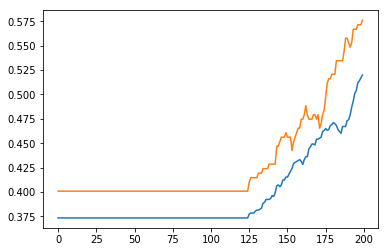

In [6]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0.9, threshold_unbalanced=0.6, epochs=200,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.5, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight={'Android': 1.65, 'iOS': 2.70, 'other': 50.2})

epoch=0 loss=0.8832857293186401 tscore=0.6165338645418327 vscore=0.5898617511520737
epoch=1 loss=0.7495404073508319 tscore=0.6105577689243028 vscore=0.5852534562211982
epoch=2 loss=0.7675696718069235 tscore=0.6444223107569721 vscore=0.6405529953917051
epoch=3 loss=0.7321316519543257 tscore=0.6205179282868526 vscore=0.5990783410138248
epoch=4 loss=0.7108590891655031 tscore=0.6852589641434262 vscore=0.6774193548387096
epoch=5 loss=0.7120464942454815 tscore=0.6284860557768924 vscore=0.6175115207373272
epoch=6 loss=0.701019559157248 tscore=0.6404382470119522 vscore=0.631336405529954
epoch=7 loss=0.6947629988104134 tscore=0.6743027888446215 vscore=0.6774193548387096
epoch=8 loss=0.6866469980665064 tscore=0.7151394422310757 vscore=0.7004608294930875
epoch=9 loss=0.6732674292448274 tscore=0.6454183266932271 vscore=0.6359447004608295


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=10 loss=0.6723087291714355 tscore=0.6643426294820717 vscore=0.6543778801843319
epoch=11 loss=0.6603240371245976 tscore=0.7679282868525896 vscore=0.7603686635944701
epoch=12 loss=0.6781651824098722 tscore=0.6424302788844621 vscore=0.6405529953917051
epoch=13 loss=0.6691259819230907 tscore=0.6553784860557769 vscore=0.6451612903225806
epoch=14 loss=0.6730638921191014 tscore=0.7828685258964143 vscore=0.783410138248848
epoch=15 loss=0.6572876431793208 tscore=0.7061752988047809 vscore=0.6912442396313364
epoch=16 loss=0.6472322731816698 tscore=0.6424302788844621 vscore=0.6497695852534562
epoch=17 loss=0.6630155541278525 tscore=0.7300796812749004 vscore=0.7373271889400922
epoch=18 loss=0.6402870481721931 tscore=0.6862549800796812 vscore=0.6589861751152074
epoch=19 loss=0.6288780237933157 tscore=0.7241035856573705 vscore=0.7142857142857143
epoch=20 loss=0.6132176979037867 tscore=0.7440239043824701 vscore=0.7511520737327189
epoch=21 loss=0.6050637424297189 tscore=0.7330677290836654 vscore=

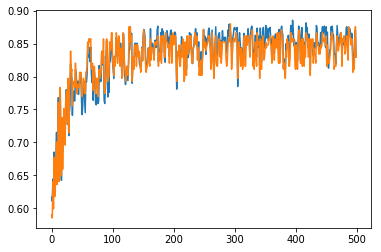

In [7]:
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

performed PCA, number of features: 4, explained variance for component:
 ['0.07', '0.02', '0.01', '0.00']
Weights used: {'Android': 1.65, 'iOS': 2.68, 'other': 50.2}
epoch=0 tscore=0.3555776892430279 vscore=0.34101382488479265
epoch=1 tscore=0.4033864541832669 vscore=0.41013824884792627
epoch=2 tscore=0.41334661354581675 vscore=0.43317972350230416
epoch=3 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=4 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=5 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=6 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=7 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=8 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=9 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=10 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=11 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=12 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=13 tscore=0.414342629

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)



epoch=22 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=23 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=24 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=25 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=26 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=27 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=28 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=29 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=30 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=31 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=32 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=33 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=34 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=35 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=36 tscore=0.41434262948207173 vscore=0.43317972350230416
epoch=37 tscore=0.41434262948207173 vscore=0.433179723

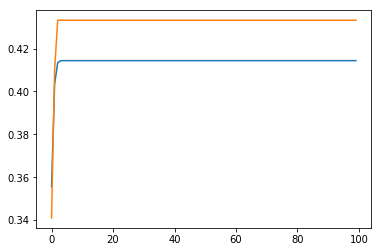

In [8]:
my_lr.train(X, y, percentage=percentage_used, std=False, pca=0.9, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [9]:
my_forest.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.910359 vscore=0.917051
Score on smaller part (41.47%) of validation set (unbalanced case): 0.82
Score on bigger part (58.53%) of validation set (unbalanced case): 0.98
Category histogram in validation set: {'iOS': 87, 'Android': 127, 'other': 3}


(231, 13) (231,)
0.9047619047619048
[0.9047619 0.        0.        0.       ]
1
(231, 4) (231,)
0.43722943722943725
[0.9047619  0.43722944 0.         0.        ]
2
(231, 13) (231,)
0.8225108225108225
[0.9047619  0.43722944 0.82251082 0.        ]
3
(231, 4) (231,)
0.46320346320346323
[0.9047619  0.43722944 0.82251082 0.46320346]
4


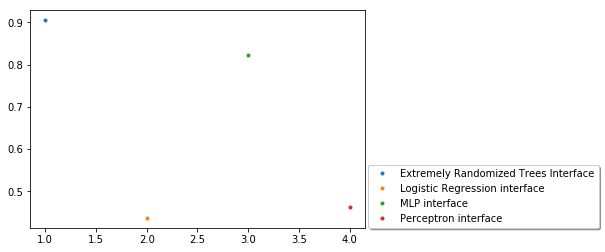

best is Extremely Randomized Trees Interface with score 0.90


In [10]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

Therefore we use this XRT to predict the rest of the column OS and keep the predictions to imput into our dataset later.

In [11]:
os_missing = best.predict(X,y, fill_up=True)

C:\Users\guglielmo\Desktop\ML\Vod++\VodafoneChallenge_Classes.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


# Urbanization

In [12]:
X = df_filled[traffic_columns]
df_filled['Urban'] = df_filled['Urban'].map(lambda x: int(x), na_action = 'ignore')
y = df_filled['Urban']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

run=1 tscore=0.335972 vscore=0.32549
run=2 tscore=0.335972 vscore=0.32549
run=3 tscore=0.335972 vscore=0.32549
run=4 tscore=0.336851 vscore=0.32549
run=5 tscore=0.336851 vscore=0.32549
run=6 tscore=0.335972 vscore=0.32549
run=7 tscore=0.336851 vscore=0.32549
run=8 tscore=0.336851 vscore=0.32549
run=9 tscore=0.336851 vscore=0.32549
run=10 tscore=0.337731 vscore=0.32549
run=11 tscore=0.337731 vscore=0.32549
run=12 tscore=0.337731 vscore=0.32549
run=13 tscore=0.33861 vscore=0.32549
run=14 tscore=0.33861 vscore=0.32549
run=15 tscore=0.33861 vscore=0.32549
run=16 tscore=0.33861 vscore=0.32549
run=17 tscore=0.33861 vscore=0.32549
run=18 tscore=0.337731 vscore=0.32549
run=19 tscore=0.337731 vscore=0.32549
run=20 tscore=0.337731 vscore=0.32549
run=21 tscore=0.337731 vscore=0.321569
run=22 tscore=0.337731 vscore=0.321569
run=23 tscore=0.33861 vscore=0.321569
run=24 tscore=0.337731 vscore=0.321569
run=25 tscore=0.337731 vscore=0.32549
run=26 tscore=0.336851 vscore=0.32549
run=27 tscore=0.336851 

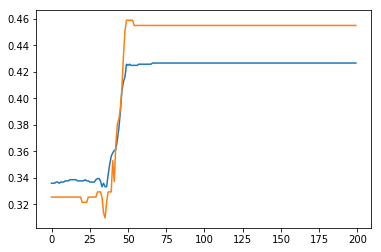

In [13]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=200,  loss='squared_hinge', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

epoch=0 loss=1.1388561402064168 tscore=0.3254177660510114 vscore=0.32941176470588235
epoch=1 loss=1.129611403196347 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=2 loss=1.1221763604039303 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=3 loss=1.1161255771344782 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=4 loss=1.1112807545489278 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=5 loss=1.1071973172368235 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=6 loss=1.1039714665865776 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=7 loss=1.1012979054668546 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=8 loss=1.0990477923642585 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=9 loss=1.0973390164968386 tscore=0.42656112576956906 vscore=0.4549019607843137


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=10 loss=1.09581602890517 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=11 loss=1.0945314937503479 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=12 loss=1.093327346540357 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=13 loss=1.0924357605387216 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=14 loss=1.091637634224572 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=15 loss=1.0908057064253434 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=16 loss=1.0900874559683187 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=17 loss=1.089414246874098 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=18 loss=1.0888159345258999 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=19 loss=1.0882189886146851 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=20 loss=1.087795471766337 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=21 loss=1.0871541667819626 tscore=0.42656112576956906 

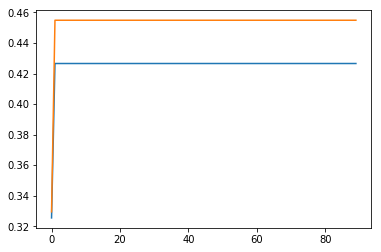

In [14]:
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)

epoch=0 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=1 tscore=0.4212840809146878 vscore=0.47058823529411764
epoch=2 tscore=0.43007915567282323 vscore=0.4627450980392157
epoch=3 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=4 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=5 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=6 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=7 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=8 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=9 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=10 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=11 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=12 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=13 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=14 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=15 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=16 tscore=0.4309586631486

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)



epoch=44 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=45 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=46 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=47 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=48 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=49 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=50 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=51 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=52 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=53 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=54 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=55 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=56 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=57 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=58 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=59 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=60 tscore=0.43095

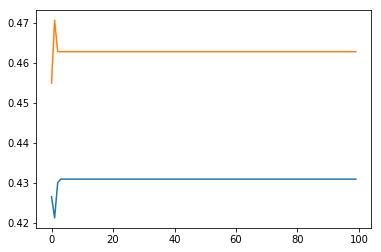

In [15]:
my_lr.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [16]:
my_forest.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.528584 vscore=0.443137


(262, 13) (262,)
0.4122137404580153
[0.41221374 0.         0.         0.        ]
1
(262, 13) (262,)
0.4389312977099237
[0.41221374 0.4389313  0.         0.        ]
2
(262, 13) (262,)
0.45038167938931295
[0.41221374 0.4389313  0.45038168 0.        ]
3
(262, 13) (262,)
0.45038167938931295
[0.41221374 0.4389313  0.45038168 0.45038168]
4


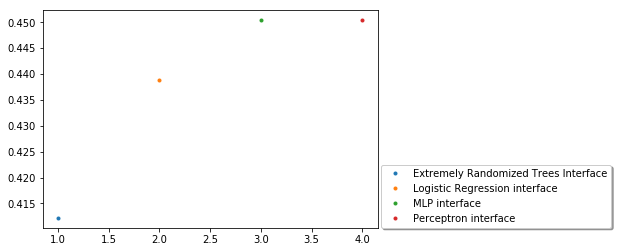

best is MLP interface with score 0.45


In [17]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

In [18]:
urbanization = best.predict(X,y, fill_up=True)

C:\Users\guglielmo\Desktop\ML\Vod++\VodafoneChallenge_Classes.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


# Numeric Age

In [19]:
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
df_filled["NumericAge"] = df_filled["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df_filled[traffic_columns]
y = df_filled['NumericAge']
build_seed = 456222
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

run=1 tscore=0.649579 vscore=0.589474
run=2 tscore=0.636572 vscore=0.6
run=3 tscore=0.620505 vscore=0.575439
run=4 tscore=0.617445 vscore=0.561404
run=5 tscore=0.617445 vscore=0.561404
run=6 tscore=0.605968 vscore=0.561404
run=7 tscore=0.607498 vscore=0.568421
run=8 tscore=0.605968 vscore=0.582456
run=9 tscore=0.602142 vscore=0.582456
run=10 tscore=0.600612 vscore=0.585965
run=11 tscore=0.603673 vscore=0.6
run=12 tscore=0.604438 vscore=0.592982
run=13 tscore=0.606733 vscore=0.592982
run=14 tscore=0.605203 vscore=0.6
run=15 tscore=0.605203 vscore=0.603509
run=16 tscore=0.604438 vscore=0.6
run=17 tscore=0.609028 vscore=0.596491
run=18 tscore=0.609793 vscore=0.589474
run=19 tscore=0.611324 vscore=0.6
run=20 tscore=0.608263 vscore=0.6
run=21 tscore=0.604438 vscore=0.592982
run=22 tscore=0.604438 vscore=0.585965
run=23 tscore=0.604438 vscore=0.585965
run=24 tscore=0.600612 vscore=0.578947
run=25 tscore=0.595256 vscore=0.585965
run=26 tscore=0.598317 vscore=0.585965
run=27 tscore=0.597552 vs

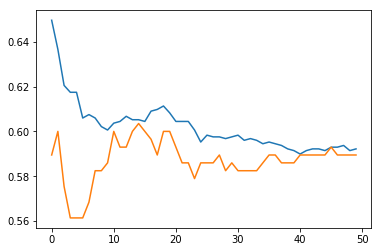

In [20]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight={2.0: 261.4, 1.0: 1.54, 0.0: 4.20})

epoch=0 loss=0.807371477777275 tscore=0.6472838561591431 vscore=0.6
epoch=1 loss=0.6778907706063428 tscore=0.6472838561591431 vscore=0.6
epoch=2 loss=0.6960129401814067 tscore=0.648814078041316 vscore=0.6035087719298246
epoch=3 loss=0.67631331763764 tscore=0.6541698546289212 vscore=0.6070175438596491
epoch=4 loss=0.672543859061838 tscore=0.6480489671002295 vscore=0.6
epoch=5 loss=0.669702337487172 tscore=0.6480489671002295 vscore=0.6
epoch=6 loss=0.6691233319097804 tscore=0.5554705432287682 vscore=0.5508771929824562
epoch=7 loss=0.6943121409231472 tscore=0.6480489671002295 vscore=0.6
epoch=8 loss=0.6726161705192022 tscore=0.6480489671002295 vscore=0.6
epoch=9 loss=0.6745267727800957 tscore=0.6273909716908952 vscore=0.5684210526315789


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=10 loss=0.6918967104751332 tscore=0.6480489671002295 vscore=0.6
epoch=11 loss=0.6693856659597254 tscore=0.6480489671002295 vscore=0.5929824561403508
epoch=12 loss=0.665885570519515 tscore=0.6480489671002295 vscore=0.6
epoch=13 loss=0.6642739023491268 tscore=0.6480489671002295 vscore=0.6
epoch=14 loss=0.6593350134498989 tscore=0.6495791889824024 vscore=0.6035087719298246
epoch=15 loss=0.6599268638462826 tscore=0.6480489671002295 vscore=0.6
epoch=16 loss=0.6733208742719036 tscore=0.6373374139250191 vscore=0.5964912280701754
epoch=17 loss=0.6691253601563862 tscore=0.6480489671002295 vscore=0.6
epoch=18 loss=0.664153733866062 tscore=0.6518745218056619 vscore=0.6070175438596491
epoch=19 loss=0.6601251918138836 tscore=0.6480489671002295 vscore=0.6
epoch=20 loss=0.6582700221821541 tscore=0.6480489671002295 vscore=0.6
epoch=21 loss=0.6615872358113616 tscore=0.6480489671002295 vscore=0.6
epoch=22 loss=0.6645033713264875 tscore=0.6511094108645754 vscore=0.6035087719298246
epoch=23 loss=0.6

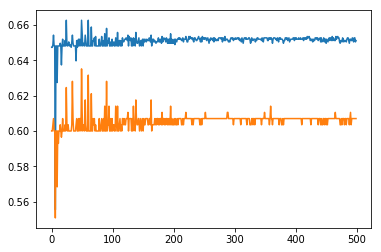

In [21]:
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.2, tol = 1e-4)

Weights used: {2.0: 261.4, 1.0: 1.54, 0.0: 2.87}
epoch=0 tscore=0.4139250191277735 vscore=0.3894736842105263
epoch=1 tscore=0.4429992348890589 vscore=0.4280701754385965
epoch=2 tscore=0.44376434583014535 vscore=0.43157894736842106
epoch=3 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=4 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=5 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=6 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=7 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=8 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=9 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=10 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=11 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=12 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=13 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=14 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=15 tscore=0.44529456771231

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=28 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=29 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=30 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=31 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=32 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=33 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=34 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=35 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=36 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=37 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=38 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=39 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=40 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=41 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=42 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=43 tscore=0.4452945677123183 vscore=0.43508771929824563
epoch=44

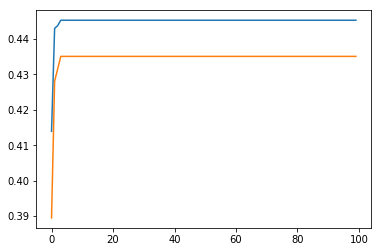

In [22]:
my_lr.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [23]:
my_forest.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.686305 vscore=0.635088
Score on smaller part (40.00%) of validation set (unbalanced case): 0.09
Score on bigger part (60.00%) of validation set (unbalanced case): 1.00
Category histogram in validation set: {0.0: 111, 1.0: 171, 2.0: 3}


(288, 13) (288,)
0.6666666666666666
[0.66666667 0.         0.         0.        ]
1
(288, 13) (288,)
0.4340277777777778
[0.66666667 0.43402778 0.         0.        ]
2
(288, 13) (288,)
0.6666666666666666
[0.66666667 0.43402778 0.66666667 0.        ]
3
(288, 13) (288,)
0.6736111111111112
[0.66666667 0.43402778 0.66666667 0.67361111]
4


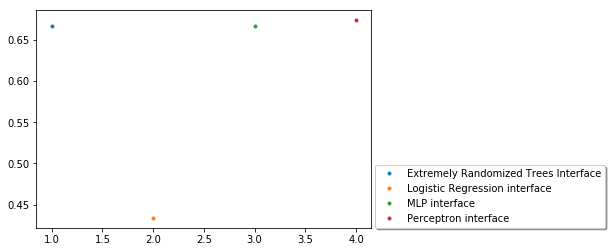

best is Perceptron interface with score 0.67


In [24]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

In [25]:
#pay attention: MLP not weighted
num_age = best.predict(X,y, fill_up=True)

C:\Users\guglielmo\Desktop\ML\Vod++\VodafoneChallenge_Classes.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


# Data Allowance

Most of the points looks like they're concentrated between 0 and 0.5. To better investigate this, let's look at the density of this column:

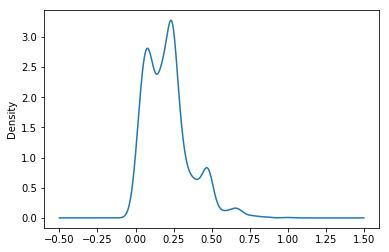

In [26]:
df_clean['DataAllowance'].plot.density()

In [27]:
mask = df_clean['DataAllowance'] > 0.5
np.sum(~mask)

1939

Therefore there are 1575 (over the 1636 not nan) which are below 0.5, so our conjecture was quite good. Given this, our idea is to take into consideration for our imputation just these X's, below 0.5, not using the outliers. We proceed using the above mask:

In [28]:
X = df_filled[traffic_columns][~mask]
df_filled['DataAllowance'] = df_filled['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataAllowance'][~mask]

build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

run=1 tscore=0.360958 vscore=0.351464
run=2 tscore=0.366483 vscore=0.372385
run=3 tscore=0.371087 vscore=0.389121
run=4 tscore=0.375691 vscore=0.393305
run=5 tscore=0.375691 vscore=0.389121
run=6 tscore=0.370166 vscore=0.384937
run=7 tscore=0.377532 vscore=0.384937
run=8 tscore=0.37477 vscore=0.384937
run=9 tscore=0.37477 vscore=0.393305
run=10 tscore=0.372928 vscore=0.384937
run=11 tscore=0.379374 vscore=0.384937
run=12 tscore=0.373849 vscore=0.376569
run=13 tscore=0.368324 vscore=0.393305
run=14 tscore=0.375691 vscore=0.384937
run=15 tscore=0.372928 vscore=0.384937
run=16 tscore=0.376611 vscore=0.389121
run=17 tscore=0.377532 vscore=0.384937
run=18 tscore=0.373849 vscore=0.384937
run=19 tscore=0.375691 vscore=0.389121
run=20 tscore=0.370166 vscore=0.380753
run=21 tscore=0.370166 vscore=0.384937
run=22 tscore=0.37477 vscore=0.376569
run=23 tscore=0.372007 vscore=0.380753
run=24 tscore=0.37477 vscore=0.389121
run=25 tscore=0.371087 vscore=0.384937
run=26 tscore=0.382136 vscore=0.384937

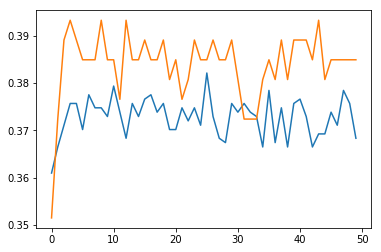

In [29]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.8053158754800716 tscore=0.07550644567219153 vscore=0.0794979079497908
epoch=1 loss=1.79263988521152 tscore=0.17679558011049723 vscore=0.20920502092050208
epoch=2 loss=1.7808944177577597 tscore=0.26243093922651933 vscore=0.28870292887029286
epoch=3 loss=1.7689749765091778 tscore=0.31952117863720075 vscore=0.3389121338912134


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=4 loss=1.7583137996546214 tscore=0.35174953959484345 vscore=0.36401673640167365
epoch=5 loss=1.7476879701851042 tscore=0.36187845303867405 vscore=0.3807531380753138
epoch=6 loss=1.7373771367576174 tscore=0.36279926335174956 vscore=0.3891213389121339
epoch=7 loss=1.728004829746177 tscore=0.36279926335174956 vscore=0.3891213389121339
epoch=8 loss=1.7187574615384587 tscore=0.36279926335174956 vscore=0.3891213389121339
epoch=9 loss=1.70985855817264 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=10 loss=1.701526075353084 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=11 loss=1.6934366143235107 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=12 loss=1.6858969370968084 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=13 loss=1.6786132454367413 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=14 loss=1.6716634575748437 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=15 loss=1.665381747821214 tscore=0.3627992633517495

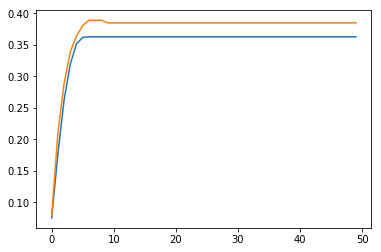

In [30]:
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (400,), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.05, tol = 1e-4)

performed PCA, number of features: 4, explained variance for component:
 ['0.07', '0.02', '0.01', '0.00']
epoch=0 tscore=0.36279926335174956 vscore=0.38493723849372385
epoch=1 tscore=0.35911602209944754 vscore=0.3807531380753138
epoch=2 tscore=0.36003683241252304 vscore=0.39330543933054396
epoch=3 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=4 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=5 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=6 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=7 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=8 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=9 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=10 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=11 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=12 tscore=0.36095764272559855 vscore=0.3891213389121339


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=13 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=14 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=15 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=16 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=17 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=18 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=19 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=20 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=21 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=22 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=23 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=24 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=25 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=26 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=27 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=28 tscore=0.36095764272559855 vscore=0.3891213389121339
epoch=29

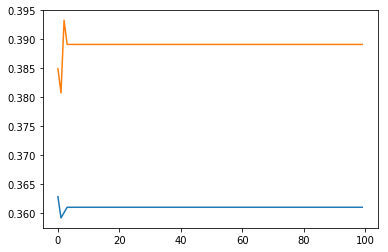

In [31]:
my_lr.train(X, y, percentage=percentage_used, std=False, pca=0.9, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [32]:
my_forest.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.435543 vscore=0.380753


(250, 13) (250,)
0.364
[0.364 0.    0.    0.   ]
1
(250, 4) (250,)
0.368
[0.364 0.368 0.    0.   ]
2
(250, 13) (250,)
0.372
[0.364 0.368 0.372 0.   ]
3
(250, 13) (250,)
0.348
[0.364 0.368 0.372 0.348]
4


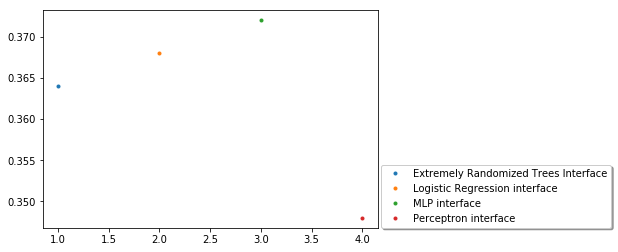

best is MLP interface with score 0.37


In [33]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

To predict, we must use the entire X and y, but with our trained MLP just on masked data.

In [34]:
X = df_filled[traffic_columns]
y = df_filled['DataAllowance']

In [35]:
data_all = best.predict(X,y, fill_up=True)

C:\Users\guglielmo\Desktop\ML\Vod++\VodafoneChallenge_Classes.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


# Monthly Data Traffic

In [36]:
X = df_filled[traffic_columns]
df_filled['MonthlyDataTraffic'] = df_filled['MonthlyDataTraffic'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyDataTraffic']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

run=1 tscore=0.235562 vscore=0.252525
run=2 tscore=0.43541 vscore=0.43771
run=3 tscore=0.409574 vscore=0.420875
run=4 tscore=0.445289 vscore=0.447811
run=5 tscore=0.433891 vscore=0.434343
run=6 tscore=0.431611 vscore=0.417508
run=7 tscore=0.461246 vscore=0.47138
run=8 tscore=0.424012 vscore=0.393939
run=9 tscore=0.417933 vscore=0.40404
run=10 tscore=0.448328 vscore=0.430976
run=11 tscore=0.458207 vscore=0.447811
run=12 tscore=0.424772 vscore=0.424242
run=13 tscore=0.427812 vscore=0.414141
run=14 tscore=0.455167 vscore=0.444444
run=15 tscore=0.430091 vscore=0.390572
run=16 tscore=0.447568 vscore=0.430976
run=17 tscore=0.433131 vscore=0.414141
run=18 tscore=0.433891 vscore=0.417508
run=19 tscore=0.441489 vscore=0.43771
run=20 tscore=0.444529 vscore=0.441077
run=21 tscore=0.459726 vscore=0.451178
run=22 tscore=0.43921 vscore=0.430976
run=23 tscore=0.444529 vscore=0.441077
run=24 tscore=0.457447 vscore=0.447811
run=25 tscore=0.458967 vscore=0.454545
run=26 tscore=0.452888 vscore=0.454545
r

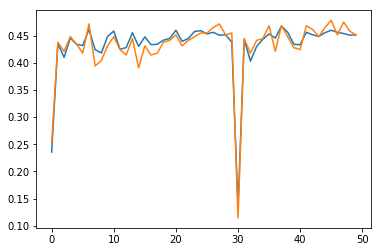

In [37]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight={'0.2': 15.86, '0.0': 1.6, '0.1': 4.50, '0.5': 1316.0, '0.3': 101.23, '0.4': 188.0, '1.0': 658.0, '0.9': 1316.0})

epoch=0 loss=1.2721702301739526 tscore=0.6238601823708206 vscore=0.67003367003367
epoch=1 loss=0.9478191047512323 tscore=0.6246200607902735 vscore=0.6734006734006734
epoch=2 loss=0.9018776141774245 tscore=0.6246200607902735 vscore=0.6632996632996633
epoch=3 loss=0.8777136164161643 tscore=0.6246200607902735 vscore=0.6734006734006734
epoch=4 loss=0.8690873260900208 tscore=0.6231003039513677 vscore=0.6666666666666666
epoch=5 loss=0.8673941638878023 tscore=0.6291793313069909 vscore=0.6734006734006734
epoch=6 loss=0.8610961666914014 tscore=0.628419452887538 vscore=0.6801346801346801


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=7 loss=0.853497963973305 tscore=0.6390577507598785 vscore=0.6801346801346801
epoch=8 loss=0.854839934715213 tscore=0.6352583586626139 vscore=0.6666666666666666
epoch=9 loss=0.8453416679933262 tscore=0.628419452887538 vscore=0.6734006734006734
epoch=10 loss=0.8591789924787715 tscore=0.6405775075987842 vscore=0.6734006734006734
epoch=11 loss=0.849542229679893 tscore=0.6314589665653495 vscore=0.6801346801346801
epoch=12 loss=0.8488907586639344 tscore=0.6534954407294833 vscore=0.6835016835016835
epoch=13 loss=0.8521252183775185 tscore=0.6458966565349544 vscore=0.6767676767676768
epoch=14 loss=0.8348050328459945 tscore=0.6428571428571429 vscore=0.6767676767676768
epoch=15 loss=0.8357672629027297 tscore=0.6443768996960486 vscore=0.6767676767676768
epoch=16 loss=0.8570697165458112 tscore=0.6550151975683891 vscore=0.6801346801346801
epoch=17 loss=0.8299139418359671 tscore=0.6580547112462006 vscore=0.6734006734006734
epoch=18 loss=0.8259174788326762 tscore=0.6580547112462006 vscore=0.6801

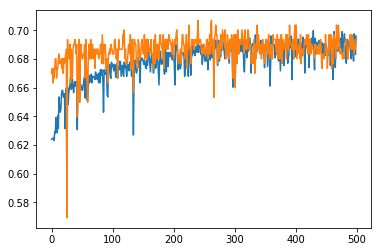

In [38]:
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

Weights used: {'0.2': 15.86, '0.0': 1.6, '0.1': 3.39, '0.5': 1316.0, '0.3': 101.23, '0.4': 188.0, '1.0': 658.0, '0.9': 1316.0}
epoch=0 tscore=0.1762917933130699 vscore=0.20202020202020202
epoch=1 tscore=0.324468085106383 vscore=0.3468013468013468
epoch=2 tscore=0.37537993920972645 vscore=0.3569023569023569
epoch=3 tscore=0.38677811550151975 vscore=0.37373737373737376
epoch=4 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=5 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=6 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=7 tscore=0.38753799392097266 vscore=0.3771043771043771


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iteration

epoch=8 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=9 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=10 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=11 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=12 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=13 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=14 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=15 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=16 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=17 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=18 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=19 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=20 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=21 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=22 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=23 tscore=0.38753799392097266 vscore=0.3771043771043771
epoch=24 t

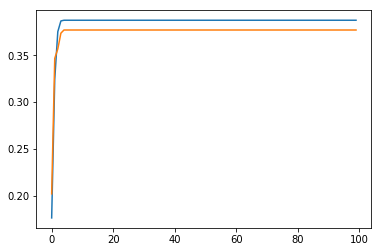

In [39]:
my_lr.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [40]:
my_forest.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.671733 vscore=0.676768
Score on smaller part (33.00%) of validation set (unbalanced case): 0.04
Score on bigger part (67.00%) of validation set (unbalanced case): 0.99
Category histogram in validation set: {'0.0': 199, '0.1': 79, '0.5': 2, '0.2': 12, '0.4': 1, '0.3': 3, '0.7': 1}


(304, 13) (304,)
0.631578947368421
[0.63157895 0.         0.         0.        ]
1
(304, 13) (304,)
0.3684210526315789
[0.63157895 0.36842105 0.         0.        ]
2
(304, 13) (304,)
0.6217105263157895
[0.63157895 0.36842105 0.62171053 0.        ]
3
(304, 13) (304,)
0.47368421052631576
[0.63157895 0.36842105 0.62171053 0.47368421]
4


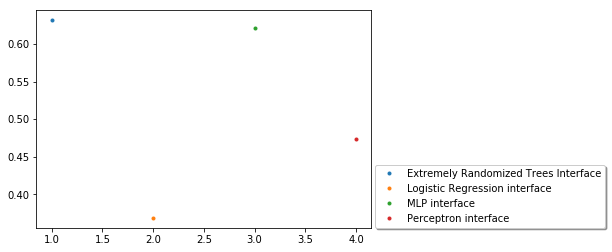

best is Extremely Randomized Trees Interface with score 0.63


In [41]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

In [42]:
data_traffic = best.predict(X,y, fill_up=True)

C:\Users\guglielmo\Desktop\ML\Vod++\VodafoneChallenge_Classes.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


# Data ARPU

In [43]:
X = df_filled[traffic_columns]
df_filled['DataArpu'] = df_filled['DataArpu'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataArpu']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

run=1 tscore=0.339476 vscore=0.295154
run=2 tscore=0.445199 vscore=0.422907
run=3 tscore=0.450048 vscore=0.45815
run=4 tscore=0.447139 vscore=0.427313
run=5 tscore=0.450048 vscore=0.449339
run=6 tscore=0.452958 vscore=0.45815
run=7 tscore=0.452958 vscore=0.449339
run=8 tscore=0.450048 vscore=0.436123
run=9 tscore=0.448109 vscore=0.444934
run=10 tscore=0.450048 vscore=0.440529
run=11 tscore=0.451988 vscore=0.449339
run=12 tscore=0.451018 vscore=0.427313
run=13 tscore=0.450048 vscore=0.436123
run=14 tscore=0.451988 vscore=0.440529
run=15 tscore=0.452958 vscore=0.431718
run=16 tscore=0.452958 vscore=0.449339
run=17 tscore=0.451988 vscore=0.449339
run=18 tscore=0.450048 vscore=0.440529
run=19 tscore=0.454898 vscore=0.436123
run=20 tscore=0.451988 vscore=0.449339
run=21 tscore=0.453928 vscore=0.444934
run=22 tscore=0.451018 vscore=0.449339
run=23 tscore=0.452958 vscore=0.444934
run=24 tscore=0.451018 vscore=0.440529
run=25 tscore=0.453928 vscore=0.444934
run=26 tscore=0.451988 vscore=0.4449

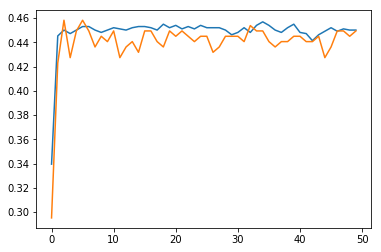

In [44]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.5733134284056978 tscore=0.35208535402521823 vscore=0.31718061674008813
epoch=1 loss=1.3368616431840834 tscore=0.45004849660523766 vscore=0.4713656387665198
epoch=2 loss=1.324970674299639 tscore=0.45004849660523766 vscore=0.46255506607929514
epoch=3 loss=1.3221796895882019 tscore=0.45489815712900095 vscore=0.4669603524229075
epoch=4 loss=1.3226513995760634 tscore=0.45489815712900095 vscore=0.4669603524229075
epoch=5 loss=1.3226663537313756 tscore=0.45586808923375366 vscore=0.4669603524229075
epoch=6 loss=1.3160300102117184 tscore=0.45004849660523766 vscore=0.42731277533039647
epoch=7 loss=1.3297636044129002 tscore=0.451988360814743 vscore=0.43171806167400884


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=8 loss=1.331816411839172 tscore=0.46071774975751695 vscore=0.45374449339207046
epoch=9 loss=1.3182152830225085 tscore=0.4481086323957323 vscore=0.42731277533039647
epoch=10 loss=1.3106562281418765 tscore=0.46071774975751695 vscore=0.45374449339207046
epoch=11 loss=1.315013782454274 tscore=0.457807953443259 vscore=0.4581497797356828
epoch=12 loss=1.3124552078020988 tscore=0.45489815712900095 vscore=0.44493392070484583
epoch=13 loss=1.3021438198737412 tscore=0.457807953443259 vscore=0.46255506607929514
epoch=14 loss=1.312502868000196 tscore=0.4597478176527643 vscore=0.4185022026431718
epoch=15 loss=1.3086960178726077 tscore=0.45877788554801163 vscore=0.4581497797356828
epoch=16 loss=1.3110715144401761 tscore=0.4568380213385063 vscore=0.4581497797356828
epoch=17 loss=1.306688512419762 tscore=0.45295829291949563 vscore=0.43171806167400884
epoch=18 loss=1.2985884591241053 tscore=0.4539282250242483 vscore=0.42290748898678415
epoch=19 loss=1.3044139808010011 tscore=0.4568380213385063 vs

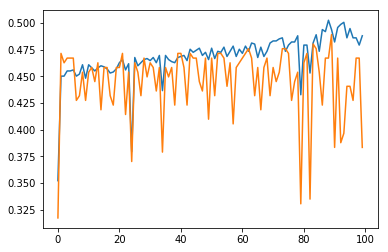

In [45]:
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
             hidden_layer_sizes = (200,50), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

epoch=0 tscore=0.4481086323957323 vscore=0.4713656387665198
epoch=1 tscore=0.4481086323957323 vscore=0.4713656387665198
epoch=2 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=3 tscore=0.457807953443259 vscore=0.45374449339207046
epoch=4 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=5 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=6 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=7 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=8 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=9 tscore=0.45877788554801163 vscore=0.45374449339207046

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)



epoch=10 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=11 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=12 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=13 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=14 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=15 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=16 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=17 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=18 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=19 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=20 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=21 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=22 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=23 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=24 tscore=0.45877788554801163 vscore=0.45374449339207046
epoch=25 tscore=0.45877788554801163 vscore=0.453744493

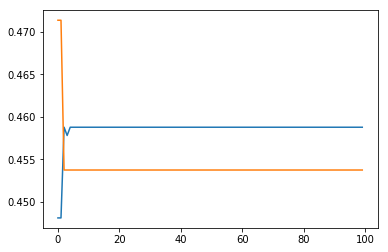

In [46]:
my_lr.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.1, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [47]:
my_forest.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.530553 vscore=0.46696


(235, 13) (235,)
0.4297872340425532
[0.42978723 0.         0.         0.        ]
1
(235, 13) (235,)
0.44680851063829785
[0.42978723 0.44680851 0.         0.        ]
2
(235, 13) (235,)
0.4425531914893617
[0.42978723 0.44680851 0.44255319 0.        ]
3
(235, 13) (235,)
0.41702127659574467
[0.42978723 0.44680851 0.44255319 0.41702128]
4


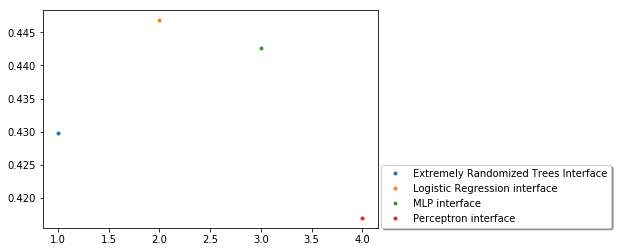

best is Logistic Regression interface with score 0.45


In [48]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

In [49]:
data_arpu = best.predict(X,y, fill_up=True)

C:\Users\guglielmo\Desktop\ML\Vod++\VodafoneChallenge_Classes.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


# Monthly Voice Traffic Count

In [50]:
X = df_filled[traffic_columns]
df_filled['MonthlyVoiceTrafficCount'] = df_filled['MonthlyVoiceTrafficCount'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyVoiceTrafficCount']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)
my_forest = trees(build_seed)

run=1 tscore=0.31383 vscore=0.333333
run=2 tscore=0.462006 vscore=0.488215
run=3 tscore=0.474164 vscore=0.494949
run=4 tscore=0.449088 vscore=0.474747
run=5 tscore=0.465805 vscore=0.474747
run=6 tscore=0.463526 vscore=0.481481
run=7 tscore=0.467325 vscore=0.47138
run=8 tscore=0.447568 vscore=0.468013
run=9 tscore=0.461246 vscore=0.481481
run=10 tscore=0.472644 vscore=0.498316
run=11 tscore=0.470365 vscore=0.498316
run=12 tscore=0.447568 vscore=0.47138
run=13 tscore=0.448328 vscore=0.47138
run=14 tscore=0.467325 vscore=0.505051
run=15 tscore=0.470365 vscore=0.494949
run=16 tscore=0.458207 vscore=0.478114
run=17 tscore=0.463526 vscore=0.488215
run=18 tscore=0.464286 vscore=0.464646
run=19 tscore=0.478723 vscore=0.491582
run=20 tscore=0.471884 vscore=0.491582
run=21 tscore=0.463526 vscore=0.488215
run=22 tscore=0.464286 vscore=0.488215
run=23 tscore=0.454407 vscore=0.484848
run=24 tscore=0.458207 vscore=0.481481
run=25 tscore=0.481003 vscore=0.501684
run=26 tscore=0.478723 vscore=0.501684

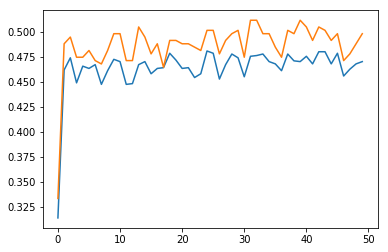

In [51]:
my_perc.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.462729973580239 tscore=0.44756838905775076 vscore=0.45791245791245794
epoch=1 loss=1.2945708379045069 tscore=0.44756838905775076 vscore=0.4612794612794613
epoch=2 loss=1.2792098171893922 tscore=0.4870820668693009 vscore=0.5151515151515151
epoch=3 loss=1.2705528992235313 tscore=0.4582066869300912 vscore=0.47474747474747475
epoch=4 loss=1.2657740823141963 tscore=0.4688449848024316 vscore=0.48148148148148145

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



epoch=5 loss=1.254091497675964 tscore=0.49240121580547114 vscore=0.5084175084175084
epoch=6 loss=1.2499368665671147 tscore=0.4848024316109423 vscore=0.48484848484848486
epoch=7 loss=1.2571265882488716 tscore=0.4688449848024316 vscore=0.45791245791245794
epoch=8 loss=1.2528858376275445 tscore=0.4673252279635258 vscore=0.45791245791245794
epoch=9 loss=1.2709898054989057 tscore=0.45972644376899696 vscore=0.47474747474747475
epoch=10 loss=1.2595100072661976 tscore=0.49772036474164133 vscore=0.5050505050505051
epoch=11 loss=1.2396118353043006 tscore=0.49620060790273557 vscore=0.494949494949495
epoch=12 loss=1.2343629585799207 tscore=0.4946808510638298 vscore=0.5016835016835017
epoch=13 loss=1.2405325405946528 tscore=0.49772036474164133 vscore=0.5084175084175084
epoch=14 loss=1.25101802473564 tscore=0.4969604863221885 vscore=0.4983164983164983
epoch=15 loss=1.235412868389773 tscore=0.4939209726443769 vscore=0.4983164983164983
epoch=16 loss=1.2345330040493476 tscore=0.5 vscore=0.505050505050

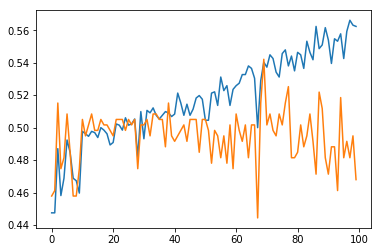

In [52]:
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
             hidden_layer_sizes = (200,50), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

epoch=0 tscore=0.44680851063829785 vscore=0.45791245791245794
epoch=1 tscore=0.44680851063829785 vscore=0.45791245791245794
epoch=2 tscore=0.4848024316109423 vscore=0.5016835016835017
epoch=3 tscore=0.4817629179331307 vscore=0.494949494949495
epoch=4 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=5 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=6 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=7 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=8 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=9 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=10 tscore=0.4817629179331307 vscore=0.4983164983164983

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)



epoch=11 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=12 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=13 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=14 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=15 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=16 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=17 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=18 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=19 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=20 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=21 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=22 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=23 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=24 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=25 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=26 tscore=0.4817629179331307 vscore=0.4983164983164983
epoch=27 tscore=0.48176

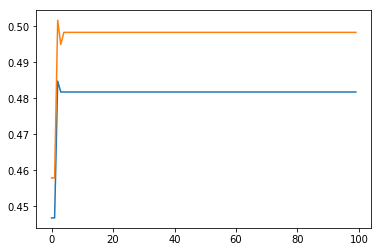

In [53]:
my_lr.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

In [54]:
my_forest.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                n_estimators = 50, max_features = "auto", criterion = "entropy", max_depth = 15,
                min_samples_split = 50, n_jobs = -1)

tscore=0.538754 vscore=0.525253


(304, 13) (304,)
0.41776315789473684
[0.41776316 0.         0.         0.        ]
1
(304, 13) (304,)
0.4276315789473684
[0.41776316 0.42763158 0.         0.        ]
2
(304, 13) (304,)
0.41118421052631576
[0.41776316 0.42763158 0.41118421 0.        ]
3
(304, 13) (304,)
0.4276315789473684
[0.41776316 0.42763158 0.41118421 0.42763158]
4


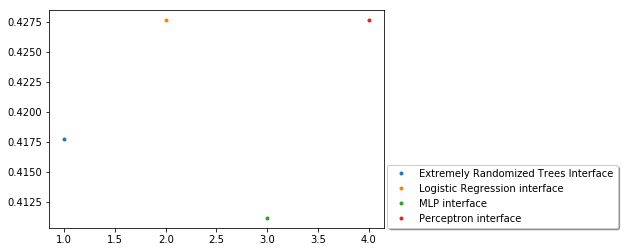

best is Logistic Regression interface with score 0.43


In [55]:
best = test_sup(my_forest, my_lr, my_MLP, my_perc)

In [56]:
voice_traffic_c = best.predict(X,y, fill_up=True)

C:\Users\guglielmo\Desktop\ML\Vod++\VodafoneChallenge_Classes.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[mask] = prediction


In [57]:
df_good = df_filled.copy()
col_to_del = ['CustomerAge', 'DevicePrice', 'Province', 'Region', 'ZipCode', 'DeviceOperatingSystem']
df_good.drop(col_to_del, axis=1, inplace=True)
df_good['MonthlySmsTrafficCount'][df_good['MonthlySmsTrafficCount'].isnull()] = df_good['MonthlySmsTrafficCount'].mean()
df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
ID                                2000 non-null int64
Product                           2000 non-null object
DataAllowance                     2000 non-null object
DataArpu                          2000 non-null object
DeviceFlag4G                      2000 non-null float64
DeviceFlagSmartphone              2000 non-null float64
MonthlyDataTraffic                2000 non-null object
MonthlyVoiceTrafficCount          2000 non-null object
CustomerGender                    2000 non-null float64
CustomerImmigrant                 2000 non-null float64
MonthlySmsTrafficCount            2000 non-null float64
File-Transfer                     2000 non-null float64
Games                             2000 non-null float64
Instant-Messaging-Applications    2000 non-null float64
Mail                              2000 non-null float64
Music-Streaming                   2000 non-null float64
Netw

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Weights Optimization
Once we have obtained the full dataset, we are ready to do clustering. Being the features really different, it doesn't not look reasonable to assume that they all have the same importance. To tackle this problem, we have decided to weight every feature. Since we had no prior guess regarding what these weights could be (i.e. a promising subset of the space that we could explore, even manually), we decided to use a supervised algorithm to optimize the parameters: KNearestNeighbors. More in details, we transformed the dataset applying some weights (still to be determined) and then we would run KNN on a training set, and test the score on a different set. The goodness of two different weights (we call them configurations) are evaluated based on the relative score of KNN under that configuration.

Once figured out how to compare weights, we just needed to come up with a way to find the best parameters. The most reasonable approach is to carry out a grid search, however an exact grid search would be computationally infeasible. Therefore we first thought of a randomized version. In our idea at the beginning, intstead of doing grid search on all the features at the same time, do it on a random subset and then repeat a few times (code of this approach is not attached). It did not perform very well and was still too costly computationally speaking (we have to consider that for each configuration we have one run of KNN, which, depending on the input size, can take between 0.2-0.9 on this dataset. On top of that, say that we propose 3 values to test for each feature, that makes 3^n_random_features * n_times to repeat. As the number of values or the number of random features to optimize over increases, the problem doesn't scale well. Then we adopted the following tactics:
1. Greedy approach: over a set of possible values for a specific feature, find the one that, keeping all the other weights constant, maximizes the score function. Repeat this procedure for a number of randomly sampled features, which should be much more of the number of features, to let the algorithm converge.  
2. Dataset Reduction: consider a very small percentage of the dataset, say 20%, onto which perform KNN. It is true that we lose precision because of less data points are used during training, though we can sensibly decrease the overall time, since KNN must be run for **every** configuration that is tested

Regarding the grid, we decided to let the weight range between 0 and 1 included (initializing the weights=1, which actually means that we are leaving the dataset unaffected). There is no need to use different intervals, as what is important is the relative scaling of the features i.e. if we multiply all the features by the same constant, nothing should change in the way the clusters are created (we observed this by changing the interval). What becomes important is the number of intermediate steps that make up the grid. Indeed, if a 100-step grid is created, at most one feature can be 100 times more important than another. Also, another thing that we observed was that, by including 0 as well among the possible values, it allows the algorithm to greedily (approximatively) decide that a certain feature is not relevant at all i.e. the best weight that can be given is 0, or alternatively, that all the values tested have the same score as the one when weight=0, which means that we can as well disregard that feature.

Good then, we have an algorithm to compare configurations, and another to greedily propose them, let's test it. We let it run overnight using 600 intermidiate values between 0 and 1, repeating the optimization 40 * n_features times (if n_features=2, then 80 times a feature as been extracted at random, and on that feature, given the actual configuration, its weight has been optimized). Below there is the graph produced, where we plot the KNN score every time a new onfiguration is accepted.

![graph](graph.jpeg "graph")

Analysing the graph, a question rises: why is the score going up and down? We expected it to be monotonically increasing, as a new configuration is accepted if the score improves. However, we noticed that due to the way we wrote the algorithm, for a given feature, we selected the best weight value by comparing them among themselves, not with respect to the overall score achieved so far.  
Also, the graph shows an interesting pattern: the score increases up to 8%, to then converge back to about 4%. Speculating on this we could say that, at first, the algorithm was exploring the space and it finally converged to a local minimum which was not optimal, things could have been different if, after a certian number of iterations, we would have compard new configurations against the best overall score so far.   
These two reasoning made us realize that we could improve the optimization by using Simulated Annealing, which we have studied last semester and is in fact made for this: randomly explore the space at first (allows to accept worsening solution, which is what our algorithm unintentionally did), and then focus on the most promising space of solutions observed and converge there to a local optimal, as the temperature decreases, only accepting strictly improving solutions anymore, as we probably should have done. Therefore we implemented Simulated Annealing for this problem and preferred to keep that output.

We have attached both codes, as we deemed interesting how we usually start from the most straightforward solution (greedy gridsearch) and then, while doing, new ideas or strategies to tackle the problem come to mind that can be better suited.

Regarding the code below, we commented out the weight optimization function call because it would take too long, we let it run overnight and we just use the weights found in that instance, instead of computing them every time.

In [58]:
df = df_good.copy()
col = df.columns[2:]

d_map = {'iOS': 1, 'Android': 2, 'other': 3}
df['OS_clean'] = df['OS_clean'].map(d_map, na_action='ignore')
cat_map = {'V-Bag': 1, 'V-Auto': 2, 'V-Pet': 3, 'V-Camera': 4}
df['Product'] = df['Product'].map(cat_map, na_action='ignore')

cat_col = [i for i in col if i not in traffic_columns]
non_cat_col = [i for i in col if i not in cat_col]
cat_col.pop(cat_col.index('MonthlySmsTrafficCount'))

X = df[col]
y = df['Product']
data = buildTrain(X, y,  perc=(0.3,0.2,0.5), std=False, pca=0, seed=None, one_hot=True, cat_col=cat_col)

knn1 = KNeighborsClassifier(n_neighbors=4)
weights = np.linspace(0, 10.0, num = 70)

grid = GridSearch(build_seed=647645)

#We do not repeat optimal_weight search since it is very time-consuming, for instance we had it running for one night, greedily
#exploring the space. Instead, for the analysis that follows, we use the weights we got after that analysis.
#optimal_weights,_ = grid.get_best(X, y, knn1, percentage=(0.3,0.2,0.5), std=False, pca=0, one_hot=True, cat_col=cat_col, epochs=1, 
                 #wmin=0, wmax=1, weights=None, start_config=None, data=data)

In [59]:
optimal_weights = np.array([0, 0, 0, 0.86956522, 0, 7.53623188, 0, 0, 6.08695652, 0,
        0, 2.89855072, 0.43478261, 0.43478261, 1.01449275, 1.01449275, 1.01449275, 1.01449275, 1.01449275, 1.88405797,
        0, 1.88405797, 0.28985507, 0, 0, 2.02898551, 0.72463768, 1.01449275, 0.14492754, 1.88405797,
        0, 0, 0, 0, 0, 1.15942029, 1.01449275, 0.28985507, 1.01449275, 1.01449275,
        1.01449275, 1.15942029, 1.01449275, 0, 0, 0, 0, 0, 1.01449275, 1.01449275,
        2.17391304, 0.43478261, 0.86956522, 0.86956522, 0, 0.57971014, 0, 1.30434783, 1.01449275, 2.17391304, 0, 0.72463768, 
        1.01449275, 2.17391304, 1.01449275, 1.01449275, 0, 0.86956522, 1.01449275, 1.01449275])

mask = optimal_weights>0

It is interesting to see which features the algorithm has decided not to be useful in classifying the product, i.e. those that have weight=0

In [166]:
data.get_one_hot().columns[~mask]

Index(['MonthlySmsTrafficCount', 'File-Transfer', 'Games', 'Mail',
       'Network-Operation', 'P2P-Applications', 'Streaming-Applications',
       'Terminals', 'DataAllowance_0.6', 'DataAllowance_0.9',
       'DataAllowance_1.0', 'DataArpu_0.5', 'DataArpu_0.6', 'DataArpu_0.7',
       'DataArpu_0.8', 'DataArpu_0.9', 'MonthlyDataTraffic_0.4',
       'MonthlyDataTraffic_0.5', 'MonthlyDataTraffic_0.7',
       'MonthlyDataTraffic_0.9', 'MonthlyDataTraffic_1.0',
       'MonthlyVoiceTrafficCount_0.6', 'MonthlyVoiceTrafficCount_0.8',
       'CustomerImmigrant_1.0', 'OS_clean_3'],
      dtype='object')

### Visual analysis of complete dataset
Once reached this point, we have finished preprocessing on data, before clustering we try to visually inspect the data. We decide to do that on three different datasets, the filled one as obtained out of data imputation, the same one after performing OneHot encoding and finally, the one-hot encoded dataset, applying the optimal weights found. We transformed the data using PC to be able to plot it. Exception made for the first dataset, where the variance explained by the first two components is almost 50%, in the other two datasets it is really low, so the plot is not really significant. In any case, in all plots we notice how the data are not clusterized with respect to the labels, even though we can identify some clusters that unsupervised learning could derive.  
We now move onto clustering.

In [60]:
X_one_hot = data.get_one_hot().loc[:, mask]
temp = np.eye(X_one_hot.shape[1]) * optimal_weights[mask]

X_mod = pd.DataFrame(np.dot(X_one_hot, temp))

[0.32550414 0.15453593 0.12925075 0.12085716 0.11668451 0.04981427
 0.03616477] 7
[0.12213514 0.10326214 0.09128413 0.08723138 0.07904252 0.06776031
 0.06519606 0.05782927 0.05182508 0.04170637 0.03630965 0.03111202
 0.02793069 0.02195727 0.01984196] 15
[0.11460387 0.10047588 0.09574976 0.08322578 0.06845386 0.06068413
 0.05297718 0.04789781 0.04408066 0.0408688  0.03866568 0.03424861
 0.03211966 0.02990148 0.02692894 0.02246544 0.01599079] 17


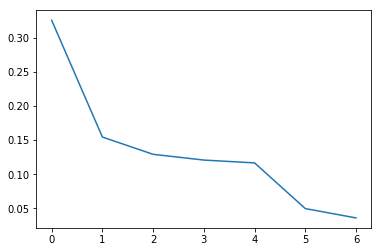

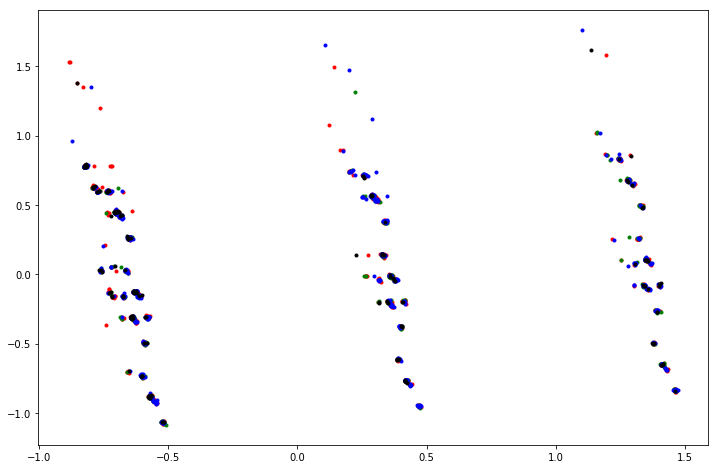

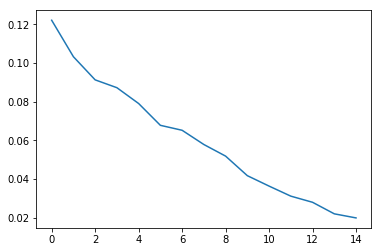

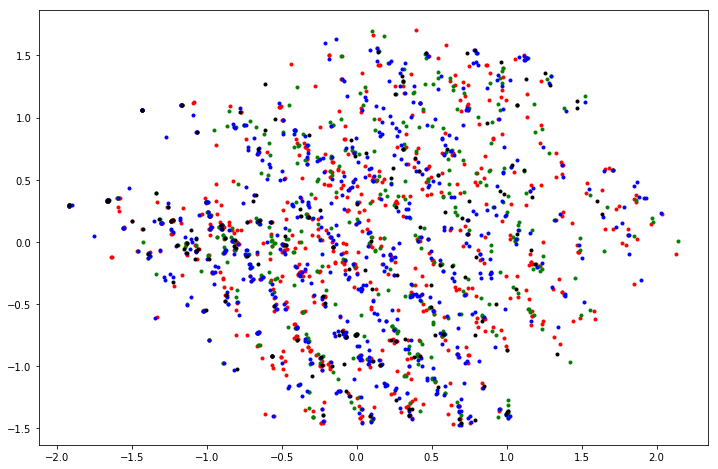

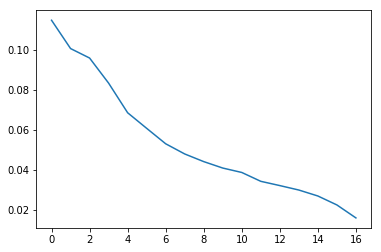

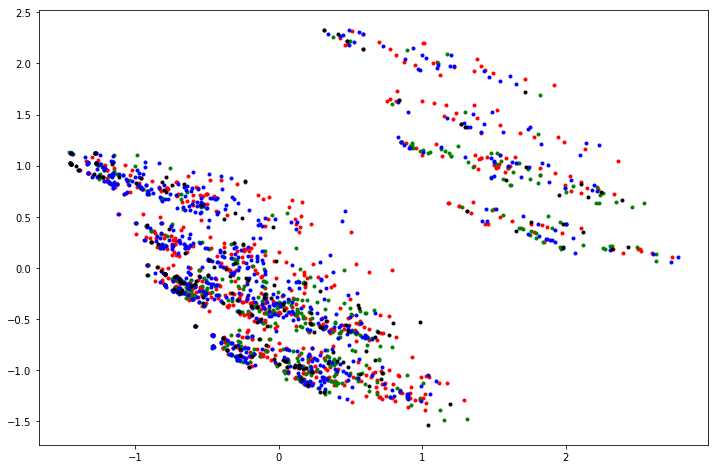

In [61]:
one_hot = X_one_hot
xs = [df[col], one_hot, X_mod]

for X in xs:
    pca = PCA(0.9)
    x_pca = pca.fit_transform(X)
    print(pca.explained_variance_ratio_, pca.n_components_)
    plt.figure()
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.figure(figsize=(12,8))
    c = ['r','g','b','black']
    cat_map = {'V-Bag': 1, 'V-Auto': 2, 'V-Pet': 3, 'V-Camera': 4}
    for i in range(1, 5):
        plt.plot(x_pca[:,0][y==i], x_pca[:,1][y==i], '.', c=c[i-1])

# Clustering
In this section we show the application (and comparison of) two supervised learning and two unsupervised learning algorithms on the dataset.

**Unsupervised (clustering).**  
We used K-Means and Hierarchical Clustering (AgglomerativeClustering). We posed the question of how can we a) compare the two and b) find the optimal parameters. Regarding the latter, it is not entirely clear how it can be done, especially for hierarchical clustering, we could guess that a good number of clusters could be around 4, since we have previous information that we can exploit. K-Means allows for a more rigorous (yet still subjective) decision rule: by plotting the loss function for different values of k, we choose the one for which the line plottet forms an elbow. In the plot below, we judged the elbow to be approximatively around k=8. Therefore we decided to use the same value as a guess for the number of neighbors for hierarchical clustering. We didn't judge it reasonable to explot the labels to compare different clusterizations, as that would "force" to prefer numbers of k resembling more the behavior of a supervised algorithm, while the whole goal of using unsupervised is to discover new patterns, not to stick or prefer the ones we already have. Having said that, we had to somehow compare the two clustering and choose the best, addressing question a) above. Definitely not an easy answer for us, we decided to exploit the labels and use the function v_measure_score from scikit.metrics to compare the clustering obtained with the labels. As already discussed, we don't believe it to be a perfect solution, but we could not identify another way.

**Supervised Learning (prediction).**
For this task, we decided to use Random Forest and Multiple Layer Perceptron, for not particular reason, other than possibly the fact that RF is not influenced by weighting the features, and MLP should be able to figure out that by itself up to a certain extent (although weighting it already can certainly be of help for the algorithm). We will see that there will not be a sensible difference between the two appoaches. Obviously, since they are trained on the true labels, they can't be used for clustering the existing data points, however it can be interesting to see with which probability a new data point is predicted to belong to a specific category. After training, we compared MLP and RF to see the best performing one, to be used to predict such probability.  
A further step that could be taken, instead of choosing just one of them, is to combine them together (ensambling) to make the prediction more robust. We haven't been able to do that due time constraints.

#### K-means analysis


 ****** K-Means: 2 ******

cluster: 0
--> top category: 1, frequency of category (variety within cluster): 40.95%, category clustering: 15.93%
Cluster size: 14.86%
--> histogram: {1: 40.95238095238095, 2: 28.095238095238095, 3: 25.238095238095237, 4: 5.714285714285714}

cluster: 1
--> top category: 1, frequency of category (variety within cluster): 37.74%, category clustering: 84.07%
Cluster size: 85.14%
--> histogram: {1: 37.73898586866168, 2: 21.612635078969245, 3: 32.418952618453865, 4: 8.229426433915211}
Overall score (doesn't consider category clustering): 39.35%, weighted: 38.25%

 ****** K-Means: 3 ******

cluster: 0
--> top category: 1, frequency of category (variety within cluster): 40.95%, category clustering: 15.93%
Cluster size: 14.86%
--> histogram: {1: 40.95238095238095, 2: 28.095238095238095, 3: 25.238095238095237, 4: 5.714285714285714}

cluster: 1
--> top category: 3, frequency of category (variety within cluster): 42.79%, category clustering: 40.86%
Cluster size: 29.9

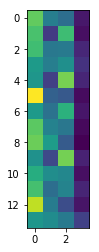

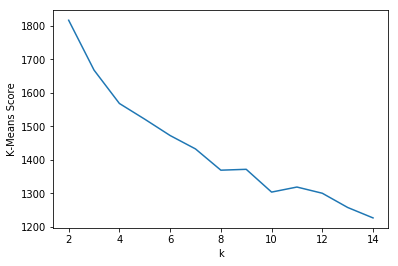

In [98]:
data = buildTrain(X_mod, y, perc=(0.7,0.15,0.15), std=False, pca=False, seed = 222253)
scores = []
a, b = 2, 15
for k in range(a, b):
    print(('\n ****** K-Means: %i ******' % k))
    km = KMeans(n_clusters=k)
    km.fit(*data.get_train())
    check_clusters(y=data.get_train()[1], clust_labels=km.labels_, v=True)
    scores.append(-km.score(*data.get_valid()))
plt.figure()
plt.xlabel('k')
plt.ylabel('K-Means Score')
plt.plot(range(a, b), scores)

#### Hierarchiacal Clustering Analysis


 ****** Hierarchical Clustering: 8 ******

cluster: 0
--> top category: 3, frequency of category (variety within cluster): 35.56%, category clustering: 17.02%
Cluster size: 15.85%
--> histogram: {4: 13.333333333333334, 3: 35.55555555555556, 1: 24.444444444444443, 2: 26.666666666666668}

cluster: 1
--> top category: 3, frequency of category (variety within cluster): 31.37%, category clustering: 17.02%
Cluster size: 17.96%
--> histogram: {4: 7.8431372549019605, 3: 31.372549019607842, 1: 31.372549019607842, 2: 29.411764705882355}

cluster: 2
--> top category: 2, frequency of category (variety within cluster): 37.50%, category clustering: 9.38%
Cluster size: 5.63%
--> histogram: {4: 12.5, 3: 18.75, 1: 31.25, 2: 37.5}

cluster: 3
--> top category: 2, frequency of category (variety within cluster): 45.45%, category clustering: 7.81%
Cluster size: 3.87%
--> histogram: {4: 9.090909090909092, 3: 27.27272727272727, 1: 18.181818181818183, 2: 45.45454545454545}

cluster: 4
--> top category: 1, fr

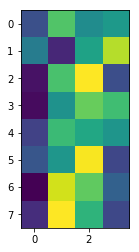

In [105]:
k = 8
print(('\n ****** Hierarchical Clustering: %i ******' % k))
hc = AgglomerativeClustering(n_clusters=k, affinity='euclidean',linkage='ward')
hc.fit(*data.get_test())
check_clusters(y=data.get_test()[1], clust_labels=hc.labels_, v=True)
score_hc = metrics.v_measure_score(data.get_test()[1], hc.labels_)

print(('\n ****** K-Means: %i ******' % k))
km = KMeans(n_clusters=k)
km.fit(*data.get_test())
check_clusters(y=data.get_test()[1], clust_labels=km.labels_, v=True)
score_km = metrics.v_measure_score(data.get_test()[1], km.labels_)

print(('\n ****** Results: %i ******' % k))
print('Scores on tests sets:\n-Hierarchical Clustering: %.2f%%\n-K-Means: %.2f%%'%(score_hc*100, score_km*100))

#### Predict probability of belonging to a class
Random Forest

In [164]:
X = df[col]
y = df['Product']
#data = buildTrain(X, y,  perc=(0.3,0.2,0.5), std=False, pca=0, seed=None, one_hot=True, cat_col=cat_col)

my_forest = trees(seed=3465, data=data)

my_forest.train(one_hot, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                max_depth=3, max_features=None, min_samples_split=0.4)
#my_forest.view_tree(feature_names=feature_names)
#my_forest.train('sfdg', y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, tree_type='XRF',
                #n_estimators = 100, max_features = 'auto', criterion = 'entropy', max_depth=5, min_samples_split = 50, n_jobs = -1)

tscore=0.419405 vscore=0.395887


Multiple Layer Perceptron

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=5.536279363924522 tscore=0.14397496087636932 vscore=0.14138817480719795
epoch=1 loss=5.515495104914212 tscore=0.14710485133020346 vscore=0.14138817480719795
epoch=2 loss=5.497493610685094 tscore=0.15023474178403756 vscore=0.14138817480719795
epoch=3 loss=5.4797318555238785 tscore=0.1486697965571205 vscore=0.14395886889460155
epoch=4 loss=5.462200106197352 tscore=0.15492957746478872 vscore=0.14652956298200515
epoch=5 loss=5.444846429374909 tscore=0.1596244131455399 vscore=0.14910025706940874
epoch=6 loss=5.4277649702482025 tscore=0.1596244131455399 vscore=0.15424164524421594
epoch=7 loss=5.410802482675381 tscore=0.15805946791862285 vscore=0.15424164524421594
epoch=8 loss=5.394220230415081 tscore=0.1596244131455399 vscore=0.15681233933161953
epoch=9 loss=5.377809412319339 tscore=0.1643192488262911 vscore=0.16452442159383032
epoch=10 loss=5.361801413529365 tscore=0.16588419405320814 vscore=0.16452442159383032
epoch=11 loss=5.345986566496202 tscore=0.1674491392801252 vscore=0.

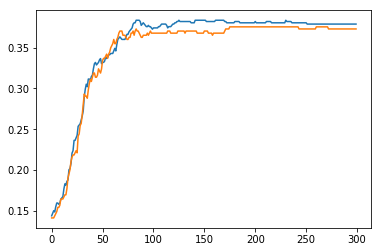

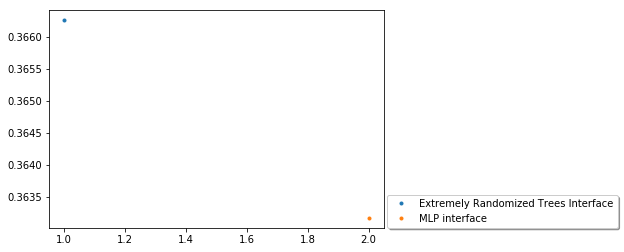

best is Extremely Randomized Trees Interface with score 0.37


In [155]:
my_MLP = MLP(data=data)
my_MLP.train(X, y, percentage=percentage_used, std=False, pca=0, threshold_unbalanced=0.6, epochs=300,
             hidden_layer_sizes = (200,50), batch_size = 600, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 13.5, tol = 1e-4)
best = test_sup(my_forest, my_MLP)